## 신경망의 추론

신경망 추론 전체 그림

In [1]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
x = np.random.randn(10, 2)
W1 = np.random.randn(2, 4)
b1 = np.random.randn(4)
W2 = np.random.randn(4, 3)
b2 = np.random.randn(3)

h = np.matmul(x, W1) + b1
a = sigmoid(h)
s = np.matmul(a, W2) + b2

계층으로 클래스화 및 순전파 구현

In [3]:
class Sigmoid:
    def __init__(self):
        self.params = []

    def forward(self, x):
        return 1 / (1 + np.exp(-x))

In [4]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
    
    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        return out

In [5]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        W1 = np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = np.random.randn(H, O)
        b2 = np.zeros(O)

        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]

        self.params = []
        for layer in self.layers:
            self.params += layer.params ## 두 개의 리스트를 결합

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [6]:
x = np.random.randn(10, 2)
model = TwoLayerNet(2, 4, 3)
s = model.predict(x)
s.shape

(10, 3)

## 신경망의 학습

Repeat 노드

In [7]:
import numpy as np

D, N = 8, 7
x = np.random.randn(1, D)
x.shape

(1, 8)

In [8]:
y = np.repeat(x, N, axis=0)
y.shape

(7, 8)

In [9]:
dy = np.random.randn(N, D)
dx = np.sum(dy, axis=0, keepdims=True)
dx.shape

(1, 8)

Sum 노드

In [10]:
import numpy as np

D, N = 8 ,7
x = np.random.randn(N, D)
y = np.sum(x, axis=0, keepdims=True)
print(f"y's shape: {y.shape}")

dy = np.random.randn(1, D)
dx = np.repeat(dy, N, axis=0)
print(f"dx's shape: {dx.shape}")

y's shape: (1, 8)
dx's shape: (7, 8)


MatMul 노드

In [11]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
    
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmult(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW ## [...]를 사용하는 것은 원래 grads[0]의 메모리 주소를 보존하기 위함임
        return dx

기울기 도출과 역전파 구현

Sigmoid 계층

In [12]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

Affine 계층

In [13]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        W, b = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

가중치 갱신

SGD

In [14]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

## 신경망으로 문제를 풀다!

스파이럴 데이터셋

In [15]:
from dataset import spiral
import matplotlib.pyplot as plt

x, t = spiral.load_data()
print('x', x.shape)
print('t', t.shape)

x (300, 2)
t (300, 3)


신경망 구현

In [16]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
        
    return x

In [17]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
    
    def forward(self, x):
        self.out = softmax(x)
        return self.out
    
    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [18]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        y = y.reshpae(1, y.size)
        t = t.reshape(1, t.size)
    
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [19]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss
    
    def backward(self, dout):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1 ## target에 해당하는 클래스만 1을 빼주면 됨. one-hot vector를 인덱스로 고쳐줬기 때문
        dx *= dout
        dx = dx / batch_size

        return dx

In [20]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        W1 = 0.01 * np.random.randn(input_size, hidden_size)
        b1 = np.zeros(hidden_size)
        W2 = 0.01 * np.random.randn(hidden_size, output_size)
        b2 = np.zeros(output_size)

        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        
        self.loss_layer = SoftmaxWithLoss()

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

학습용 코드

In [21]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [22]:
from dataset import spiral
import matplotlib.pyplot as plt

In [23]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d | 반복 %d / %d | 손실 %.2f'% (epoch+1, iters+1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| 에폭 1 | 반복 10 / 10 | 손실 1.13
| 에폭 2 | 반복 10 / 10 | 손실 1.13
| 에폭 3 | 반복 10 / 10 | 손실 1.12
| 에폭 4 | 반복 10 / 10 | 손실 1.12
| 에폭 5 | 반복 10 / 10 | 손실 1.11
| 에폭 6 | 반복 10 / 10 | 손실 1.14
| 에폭 7 | 반복 10 / 10 | 손실 1.16
| 에폭 8 | 반복 10 / 10 | 손실 1.11
| 에폭 9 | 반복 10 / 10 | 손실 1.12
| 에폭 10 | 반복 10 / 10 | 손실 1.13
| 에폭 11 | 반복 10 / 10 | 손실 1.12
| 에폭 12 | 반복 10 / 10 | 손실 1.11
| 에폭 13 | 반복 10 / 10 | 손실 1.09
| 에폭 14 | 반복 10 / 10 | 손실 1.08
| 에폭 15 | 반복 10 / 10 | 손실 1.04
| 에폭 16 | 반복 10 / 10 | 손실 1.03
| 에폭 17 | 반복 10 / 10 | 손실 0.96
| 에폭 18 | 반복 10 / 10 | 손실 0.92
| 에폭 19 | 반복 10 / 10 | 손실 0.92
| 에폭 20 | 반복 10 / 10 | 손실 0.87
| 에폭 21 | 반복 10 / 10 | 손실 0.85
| 에폭 22 | 반복 10 / 10 | 손실 0.82
| 에폭 23 | 반복 10 / 10 | 손실 0.79
| 에폭 24 | 반복 10 / 10 | 손실 0.78
| 에폭 25 | 반복 10 / 10 | 손실 0.82
| 에폭 26 | 반복 10 / 10 | 손실 0.78
| 에폭 27 | 반복 10 / 10 | 손실 0.76
| 에폭 28 | 반복 10 / 10 | 손실 0.76
| 에폭 29 | 반복 10 / 10 | 손실 0.78
| 에폭 30 | 반복 10 / 10 | 손실 0.75
| 에폭 31 | 반복 10 / 10 | 손실 0.78
| 에폭 32 | 반복 10 / 10 | 손실 0.77
| 에폭 33 | 반복 10 /

In [24]:
len(loss_list)

300

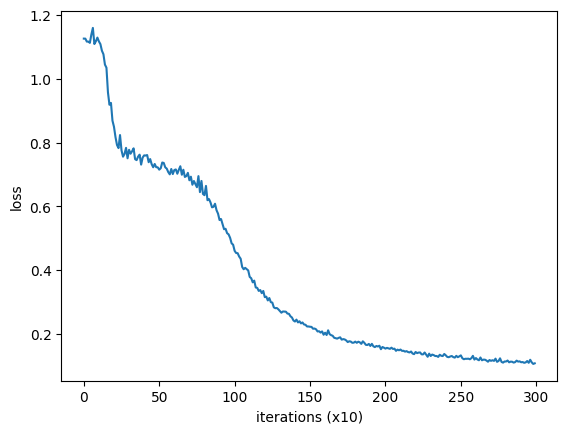

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_list)), loss_list)
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

하이퍼 파라미터 튜닝

In [26]:
max_epoch = 300
batch_size = 30
hidden_size = 15
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list_2 = []

for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d | 반복 %d / %d | 손실 %.2f'% (epoch+1, iters+1, max_iters, avg_loss))
            loss_list_2.append(avg_loss)
            total_loss, loss_count = 0, 0

| 에폭 1 | 반복 10 / 10 | 손실 1.19
| 에폭 2 | 반복 10 / 10 | 손실 1.17
| 에폭 3 | 반복 10 / 10 | 손실 1.14
| 에폭 4 | 반복 10 / 10 | 손실 1.16
| 에폭 5 | 반복 10 / 10 | 손실 1.17
| 에폭 6 | 반복 10 / 10 | 손실 1.18
| 에폭 7 | 반복 10 / 10 | 손실 1.14
| 에폭 8 | 반복 10 / 10 | 손실 1.10
| 에폭 9 | 반복 10 / 10 | 손실 1.13
| 에폭 10 | 반복 10 / 10 | 손실 1.19
| 에폭 11 | 반복 10 / 10 | 손실 1.10
| 에폭 12 | 반복 10 / 10 | 손실 1.10
| 에폭 13 | 반복 10 / 10 | 손실 1.08
| 에폭 14 | 반복 10 / 10 | 손실 0.98
| 에폭 15 | 반복 10 / 10 | 손실 0.95
| 에폭 16 | 반복 10 / 10 | 손실 0.89
| 에폭 17 | 반복 10 / 10 | 손실 0.89
| 에폭 18 | 반복 10 / 10 | 손실 0.85
| 에폭 19 | 반복 10 / 10 | 손실 0.85
| 에폭 20 | 반복 10 / 10 | 손실 0.80
| 에폭 21 | 반복 10 / 10 | 손실 0.81
| 에폭 22 | 반복 10 / 10 | 손실 0.79
| 에폭 23 | 반복 10 / 10 | 손실 0.78
| 에폭 24 | 반복 10 / 10 | 손실 0.75
| 에폭 25 | 반복 10 / 10 | 손실 0.76
| 에폭 26 | 반복 10 / 10 | 손실 0.75
| 에폭 27 | 반복 10 / 10 | 손실 0.78
| 에폭 28 | 반복 10 / 10 | 손실 0.76
| 에폭 29 | 반복 10 / 10 | 손실 0.75
| 에폭 30 | 반복 10 / 10 | 손실 0.74
| 에폭 31 | 반복 10 / 10 | 손실 0.75
| 에폭 32 | 반복 10 / 10 | 손실 0.75
| 에폭 33 | 반복 10 /

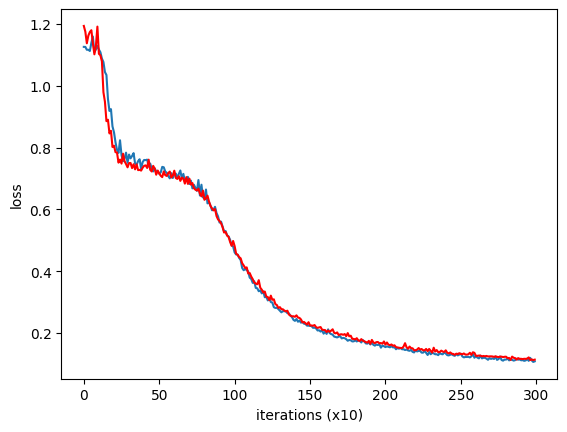

In [28]:
plt.plot(range(len(loss_list_2)), loss_list,)
plt.plot(range(len(loss_list_2)), loss_list_2, color='red')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

In [29]:
max_epoch = 300
batch_size = 30
hidden_size = 30
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list_3 = []

for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d | 반복 %d / %d | 손실 %.2f'% (epoch+1, iters+1, max_iters, avg_loss))
            loss_list_3.append(avg_loss)
            total_loss, loss_count = 0, 0

| 에폭 1 | 반복 10 / 10 | 손실 1.52
| 에폭 2 | 반복 10 / 10 | 손실 1.61
| 에폭 3 | 반복 10 / 10 | 손실 1.44
| 에폭 4 | 반복 10 / 10 | 손실 1.28
| 에폭 5 | 반복 10 / 10 | 손실 1.42
| 에폭 6 | 반복 10 / 10 | 손실 1.28
| 에폭 7 | 반복 10 / 10 | 손실 1.24
| 에폭 8 | 반복 10 / 10 | 손실 1.38
| 에폭 9 | 반복 10 / 10 | 손실 1.14
| 에폭 10 | 반복 10 / 10 | 손실 1.16
| 에폭 11 | 반복 10 / 10 | 손실 1.12
| 에폭 12 | 반복 10 / 10 | 손실 1.09
| 에폭 13 | 반복 10 / 10 | 손실 1.15
| 에폭 14 | 반복 10 / 10 | 손실 0.97
| 에폭 15 | 반복 10 / 10 | 손실 1.02
| 에폭 16 | 반복 10 / 10 | 손실 0.95
| 에폭 17 | 반복 10 / 10 | 손실 0.95
| 에폭 18 | 반복 10 / 10 | 손실 0.87
| 에폭 19 | 반복 10 / 10 | 손실 0.87
| 에폭 20 | 반복 10 / 10 | 손실 0.83
| 에폭 21 | 반복 10 / 10 | 손실 0.86
| 에폭 22 | 반복 10 / 10 | 손실 0.83
| 에폭 23 | 반복 10 / 10 | 손실 0.78
| 에폭 24 | 반복 10 / 10 | 손실 0.82
| 에폭 25 | 반복 10 / 10 | 손실 0.79
| 에폭 26 | 반복 10 / 10 | 손실 0.83
| 에폭 27 | 반복 10 / 10 | 손실 0.79
| 에폭 28 | 반복 10 / 10 | 손실 0.76
| 에폭 29 | 반복 10 / 10 | 손실 0.77
| 에폭 30 | 반복 10 / 10 | 손실 0.77
| 에폭 31 | 반복 10 / 10 | 손실 0.75
| 에폭 32 | 반복 10 / 10 | 손실 0.74
| 에폭 33 | 반복 10 /

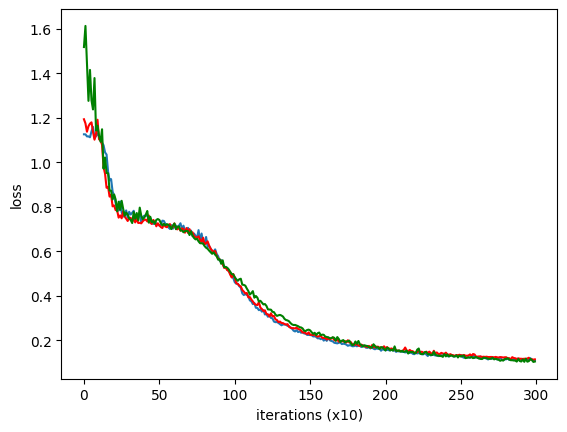

In [30]:
plt.plot(range(len(loss_list_2)), loss_list,)
plt.plot(range(len(loss_list_2)), loss_list_2, color='red')
plt.plot(range(len(loss_list_2)), loss_list_3, color='green')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

Trainer 클래스

| 에폭 1 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 2 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 3 |  반복 1 / 10 | 시간 0[s] | 손실 1.13
| 에폭 4 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 5 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 6 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 7 |  반복 1 / 10 | 시간 0[s] | 손실 1.14
| 에폭 8 |  반복 1 / 10 | 시간 0[s] | 손실 1.16
| 에폭 9 |  반복 1 / 10 | 시간 0[s] | 손실 1.11
| 에폭 10 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 11 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 12 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 13 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 14 |  반복 1 / 10 | 시간 0[s] | 손실 1.09
| 에폭 15 |  반복 1 / 10 | 시간 0[s] | 손실 1.08
| 에폭 16 |  반복 1 / 10 | 시간 0[s] | 손실 1.04
| 에폭 17 |  반복 1 / 10 | 시간 0[s] | 손실 1.03
| 에폭 18 |  반복 1 / 10 | 시간 0[s] | 손실 0.94
| 에폭 19 |  반복 1 / 10 | 시간 0[s] | 손실 0.92
| 에폭 20 |  반복 1 / 10 | 시간 0[s] | 손실 0.92
| 에폭 21 |  반복 1 / 10 | 시간 0[s] | 손실 0.87
| 에폭 22 |  반복 1 / 10 | 시간 0[s] | 손실 0.85
| 에폭 23 |  반복 1 / 10 | 시간 0[s] | 손실 0.80
| 에폭 24 |  반복 1 / 10 | 시간 0[s] | 손실 0.79
| 에폭 25 |  반복 1 / 10 | 시간

/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chanmuzi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


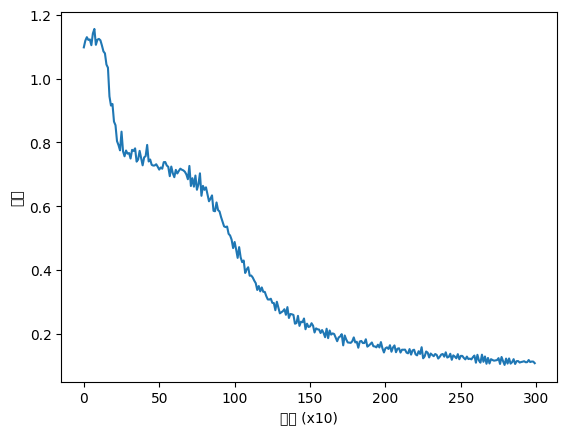

In [136]:
from common.trainer import Trainer

## 실험 포인트
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t , max_epoch, batch_size, eval_interval=10)
trainer.plot()

## 계산 고속화

비트 정밀도

In [137]:
import numpy as np
a = np.random.randn(3)
a.dtype

dtype('float64')

In [138]:
b = np.random.randn(3).astype(np.float32)
print(b.dtype)

c = np.random.randn(3).astype('f')
print(c.dtype)

float32
float32


GPU(쿠파이)

In [ ]:
## 맥 환경이라 코랩에서 실행해봐야함. 설치 자체가 불가능한 환경
import cupy as cp

x = cp.arange(6).reshape(2, 3).astype('f')
print(x)
print(x.sum(axis=1))